In [1]:
# Load pickled data
import pickle
import numpy as np

training_file = 'data/classifier/train.pkl'
testing_file = 'data/classifier/val.pkl'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = np.array(train['images']).astype(np.float32), np.array(train['labels'])
X_test, y_test = np.array(test['images']).astype(np.float32), np.array(test['labels'])

In [2]:
import tensorflow as tf

# number of classes
# 'green':0, 'red':1, 'yellow':2, 'off':3
n_classes = 4

# Input Placehoders
X = tf.placeholder(tf.float32, (None, 32, 32, 3), name = 'input_image')
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

# Layer 1: Convolutional Layer
W1 = tf.Variable(tf.truncated_normal([3, 3, 3, 16], mean=0, stddev=0.1))
b1 = tf.Variable(tf.constant(0.1, shape = [16]))
conv1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME'), b1))
conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Layer 2: Convolutional Layer
W2 = tf.Variable(tf.truncated_normal([3, 3, 16, 32], mean=0, stddev=0.1))
b2 = tf.Variable(tf.constant(0.1, shape = [32]))
conv2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv1, W2, strides=[1, 1, 1, 1], padding='SAME'), b2))
conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Layer 3: Convolutional Layer
W3 = tf.Variable(tf.truncated_normal([3, 3, 32, 64], mean=0, stddev=0.1))
b3 = tf.Variable(tf.constant(0.1, shape = [64]))
conv3 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv2, W3, strides=[1, 1, 1, 1], padding='SAME'), b3))
conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

fc1_depth = 258
fc2_depth = 128

# Layer 3: Full Connected Layer
flat_dim = 4 * 4 * 64
flatten = tf.reshape(conv3, [-1, flat_dim])
fc_W1 = tf.Variable(tf.truncated_normal([flat_dim, fc1_depth], mean=0, stddev=1.0/flat_dim))
fc_b1 = tf.Variable(tf.constant(0.1, shape = [fc1_depth]))
fc1 = tf.nn.relu(tf.add(tf.matmul(flatten, fc_W1), fc_b1))

fc_W2 = tf.Variable(tf.truncated_normal([fc1_depth, fc2_depth], mean=0, stddev=1.0/fc1_depth))
fc_b2 = tf.Variable(tf.constant(0.1, shape = [fc2_depth]))
fc2 = tf.nn.relu(tf.add(tf.matmul(fc1, fc_W2), fc_b2))

# Layer 5: Output Layer
fc_W3 = tf.Variable(tf.truncated_normal([fc2_depth, n_classes], mean=0, stddev=1.0/fc2_depth))
fc_b3 = tf.Variable(tf.constant(0.1, shape = [n_classes]))
logit = tf.add(tf.matmul(fc2, fc_W3), fc_b3)

In [3]:
### Train your model here.
### Feel free to use as many code cells as needed.
lrate = 0.001
batch_size = 128

# define the cross entropy loss opertation
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logit, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
# L2 regularization
#l2_loss = tf.constant(0.0)
#for weight in [W1, W2, W3, W4, W_out]:
#    l2_loss += tf.nn.l2_loss(weight)
#l2_weight = tf.placeholder(tf.float32)
#weighted_loss_operation = loss_operation +  l2_weight * l2_loss
weighted_loss_operation = loss_operation

# define the Adam optimizer and the training operation
optimizer = tf.train.AdamOptimizer(learning_rate = lrate)
training_operation = optimizer.minimize(weighted_loss_operation)

# define the accuracy calculation operation
prediction = tf.argmax(logit, 1, name = 'prediction')
correct_prediction = tf.equal(prediction, tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [4]:
# evaluate the accuracy given a set of images and labels
def evaluate(X_, y_):
    num_examples = len(X_)
    total_accuracy = 0
    total_loss = 0.0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        end = offset + batch_size
        batch_X, batch_y = X_[offset : end], y_[offset : end]
        accuracy, loss = sess.run([accuracy_operation, loss_operation] ,
                                     feed_dict={X: batch_X, y: batch_y})
        total_accuracy += (accuracy * len(batch_X))
        total_loss += (loss * len(batch_X))
    return total_accuracy / num_examples, total_loss / num_examples

In [6]:
from sklearn.utils import shuffle
epoches=30

saver = tf.train.Saver()
train_accuracy_list = []
valid_accuracy_list = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training...")
    print()
    for i in range(epoches):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_X, batch_y = X_train[offset : end], y_train[offset : end]
            sess.run(training_operation, feed_dict={X: batch_X, y: batch_y})
        train_accuracy, loss = evaluate(X_train, y_train)
        valid_accuracy, _ = evaluate(X_test, y_test)
        print("EPOCH {} ...".format(i+1))
        print("Average Train Loss = {:.3f}".format(loss))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print("Valid Accuracy = {:.3f}".format(valid_accuracy))
        train_accuracy_list.append(train_accuracy)
        valid_accuracy_list.append(valid_accuracy)
    saver.save(sess, "models/classifier/model.ckpt")
    tf.train.write_graph(sess.graph_def, 'models/classifier', 'graph.pb', as_text=False)
    # saver.restore(sess, "models/classifier/model.ckpt") 

Training...

EPOCH 1 ...
Average Train Loss = 0.090
Train Accuracy = 0.969
Valid Accuracy = 0.970
EPOCH 2 ...
Average Train Loss = 0.066
Train Accuracy = 0.978
Valid Accuracy = 0.970
EPOCH 3 ...
Average Train Loss = 0.050
Train Accuracy = 0.987
Valid Accuracy = 0.985
EPOCH 4 ...
Average Train Loss = 0.048
Train Accuracy = 0.988
Valid Accuracy = 0.982
EPOCH 5 ...
Average Train Loss = 0.042
Train Accuracy = 0.991
Valid Accuracy = 0.992
EPOCH 6 ...
Average Train Loss = 0.032
Train Accuracy = 0.992
Valid Accuracy = 0.986
EPOCH 7 ...
Average Train Loss = 0.033
Train Accuracy = 0.991
Valid Accuracy = 0.985
EPOCH 8 ...
Average Train Loss = 0.025
Train Accuracy = 0.994
Valid Accuracy = 0.989
EPOCH 9 ...
Average Train Loss = 0.029
Train Accuracy = 0.992
Valid Accuracy = 0.991
EPOCH 10 ...
Average Train Loss = 0.023
Train Accuracy = 0.994
Valid Accuracy = 0.990
EPOCH 11 ...
Average Train Loss = 0.034
Train Accuracy = 0.988
Valid Accuracy = 0.983
EPOCH 12 ...
Average Train Loss = 0.026
Train Accu

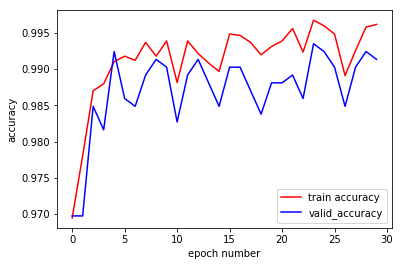

In [7]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
plt.plot(range(epoches), train_accuracy_list, 'r', label = 'train accuracy')
plt.plot(range(epoches), valid_accuracy_list, 'b', label = 'valid_accuracy')
plt.xlabel("epoch number")
plt.ylabel("accuracy")
plt.legend(loc = 'lower right')